# HW3: Regression

## Setup

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# plt formatting

from matplotlib import pylab
params = {'xtick.labelsize': 18,
'ytick.labelsize': 18,
'axes.titlesize' : 22,
'axes.labelsize' : 20,
'legend.fontsize': 18,
'legend.title_fontsize': 22,
'figure.titlesize': 24 }
pylab.rcParams.update(params)

In [3]:
# load data

from sklearn.model_selection import train_test_split

!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
dataset = pd.read_csv(filename)
train_raw, test_raw = train_test_split(dataset, test_size=0.2, random_state=103)

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving data_HW3.csv to data_HW3.csv


## Preprocessing

In [4]:
# fill missing values in PCR-02, before plotting histograms
PCR_02_median = train_raw.PCR_02.median()
train_raw = train_raw.fillna(value={"PCR_02": PCR_02_median})
test_raw = test_raw.fillna(value={"PCR_02": PCR_02_median})

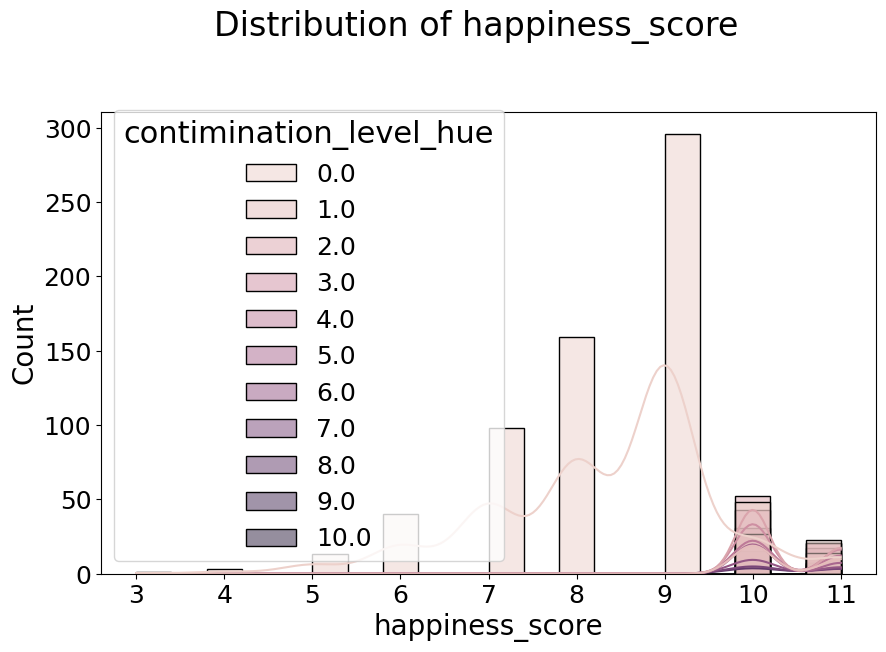

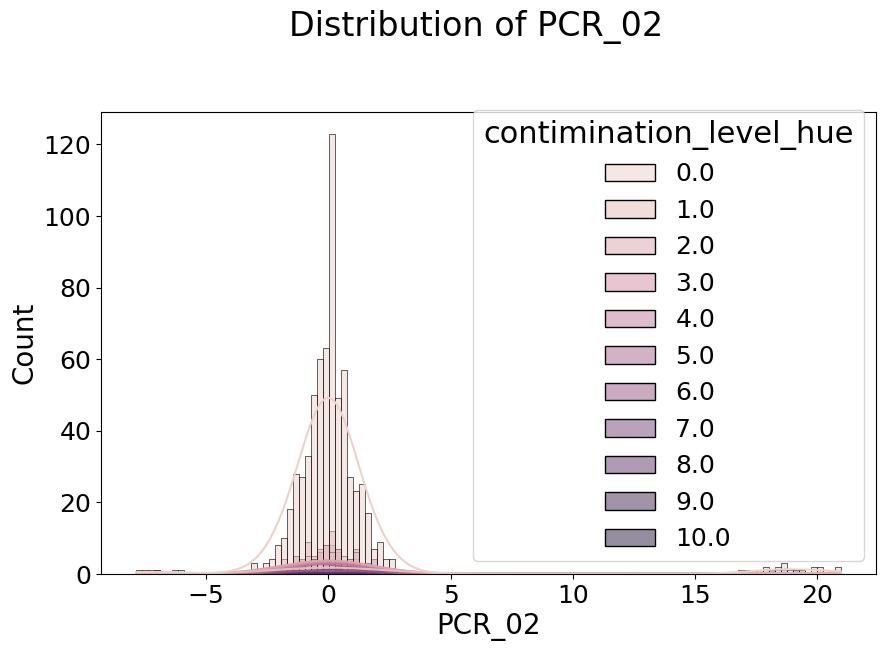

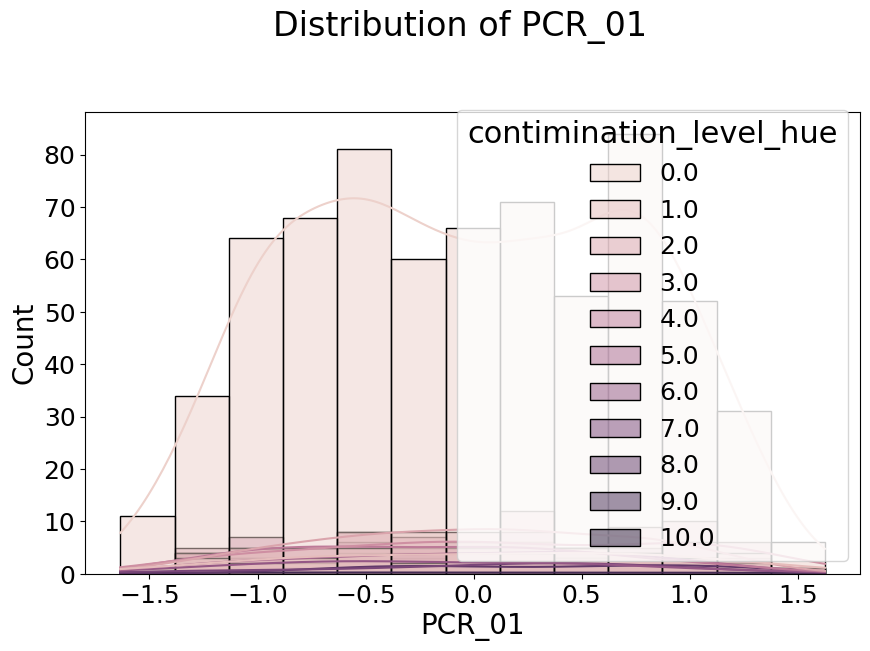

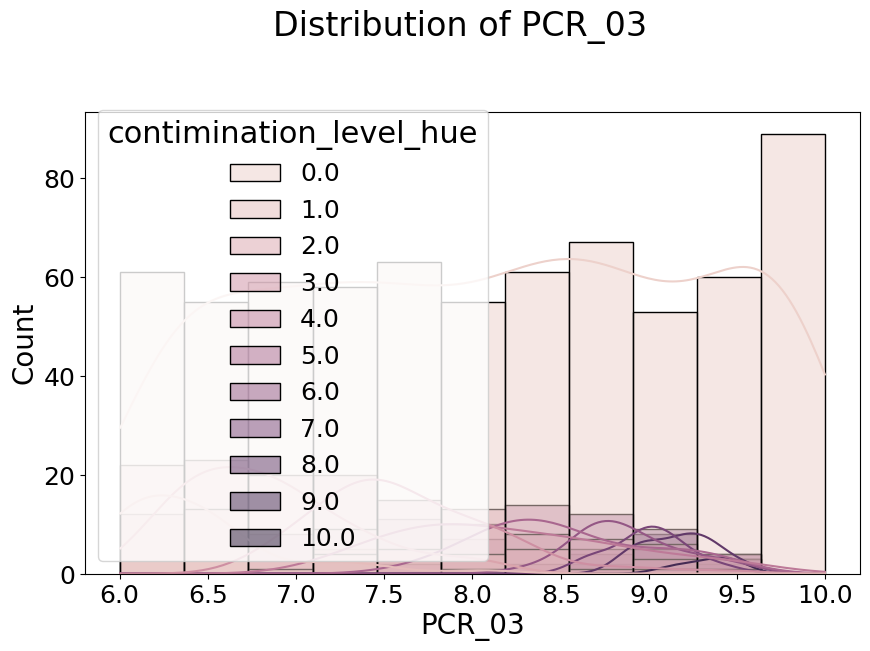

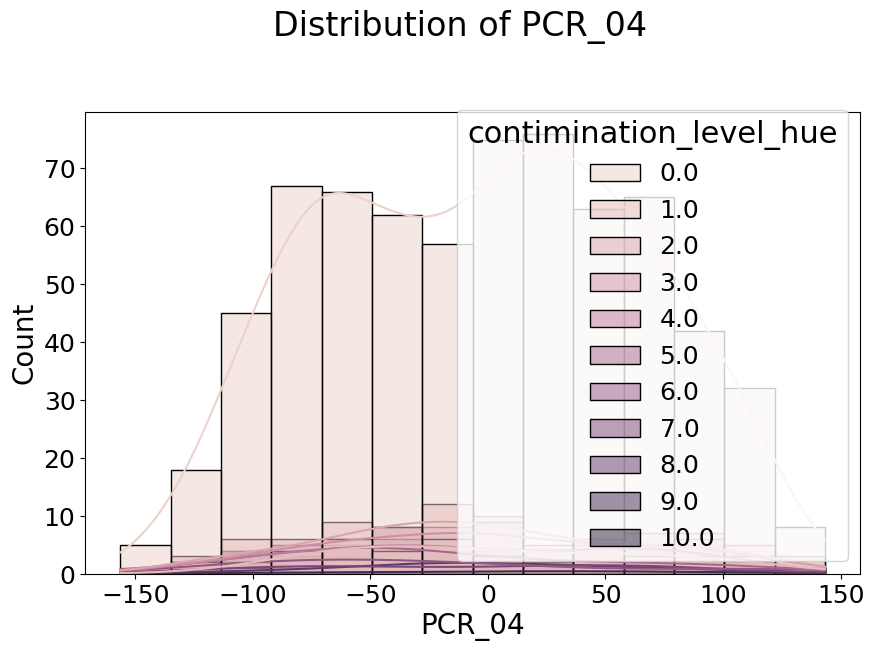

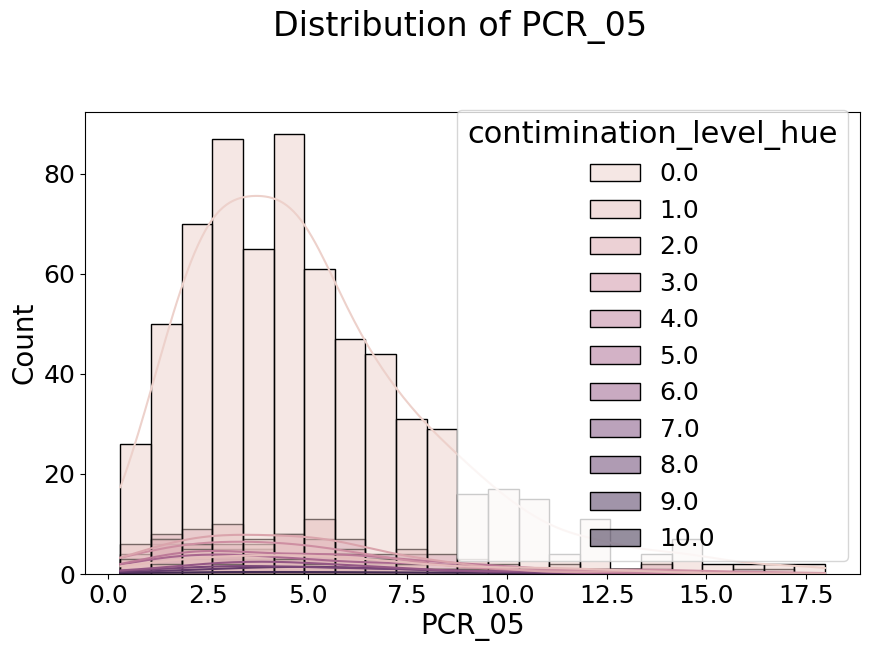

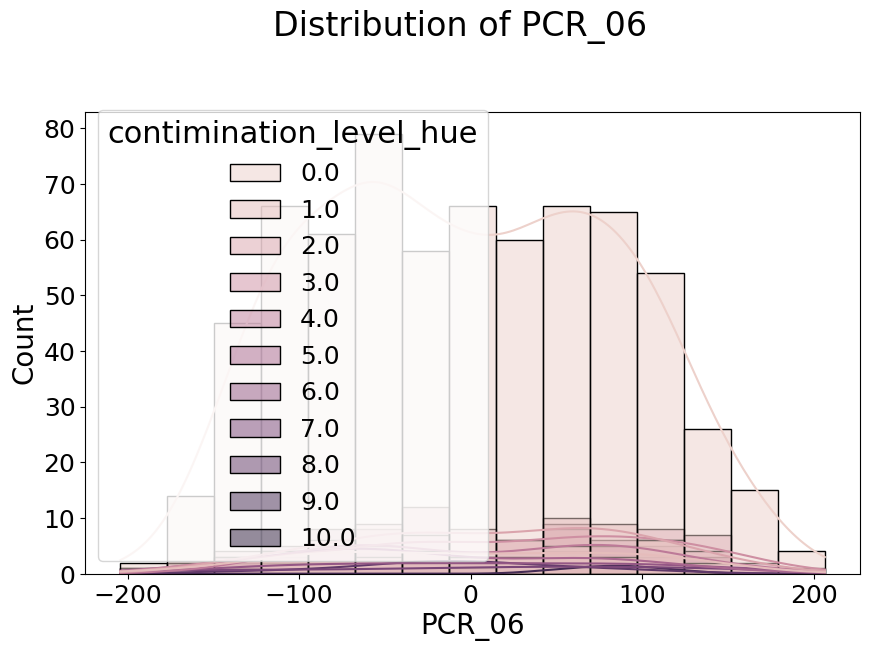

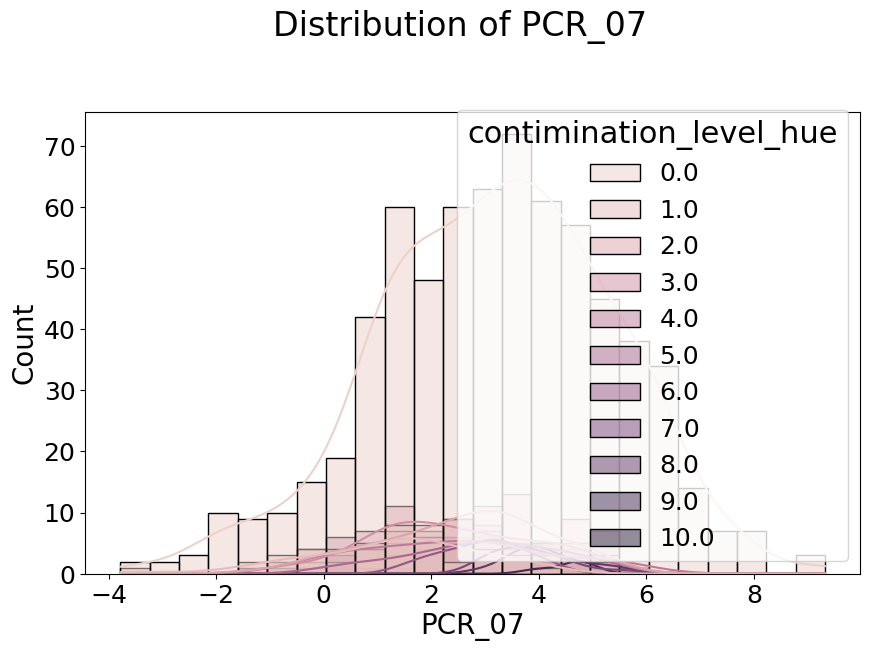

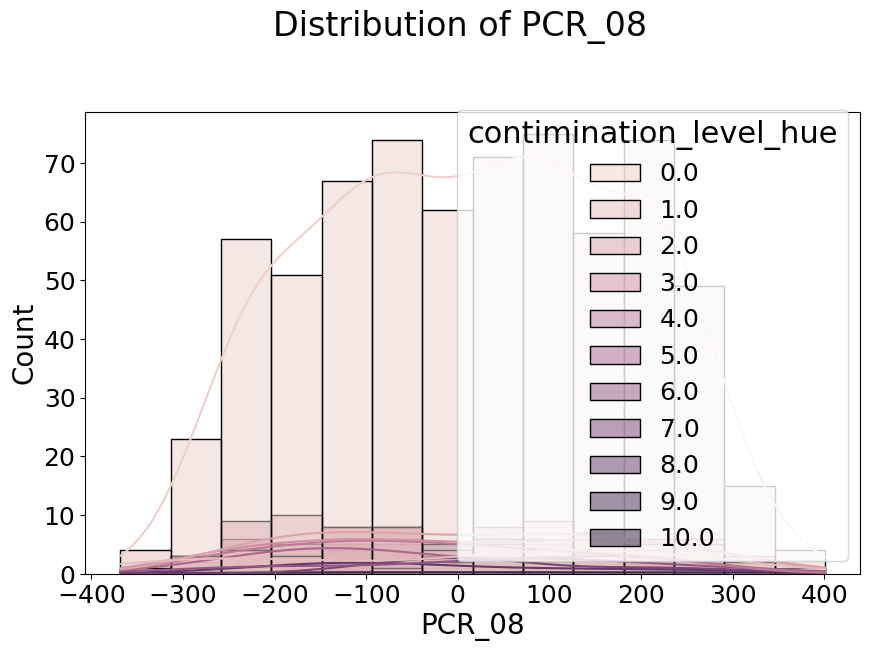

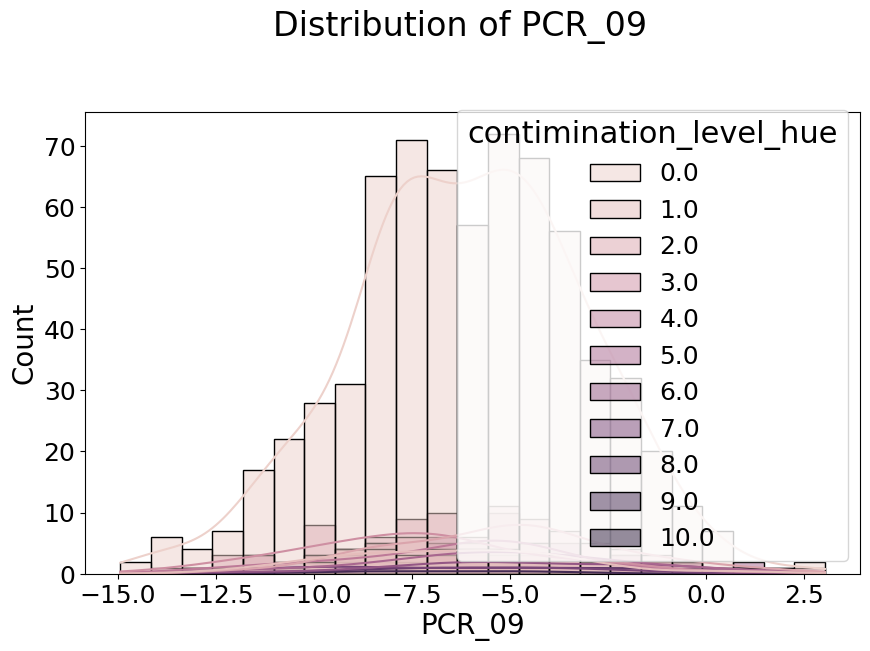

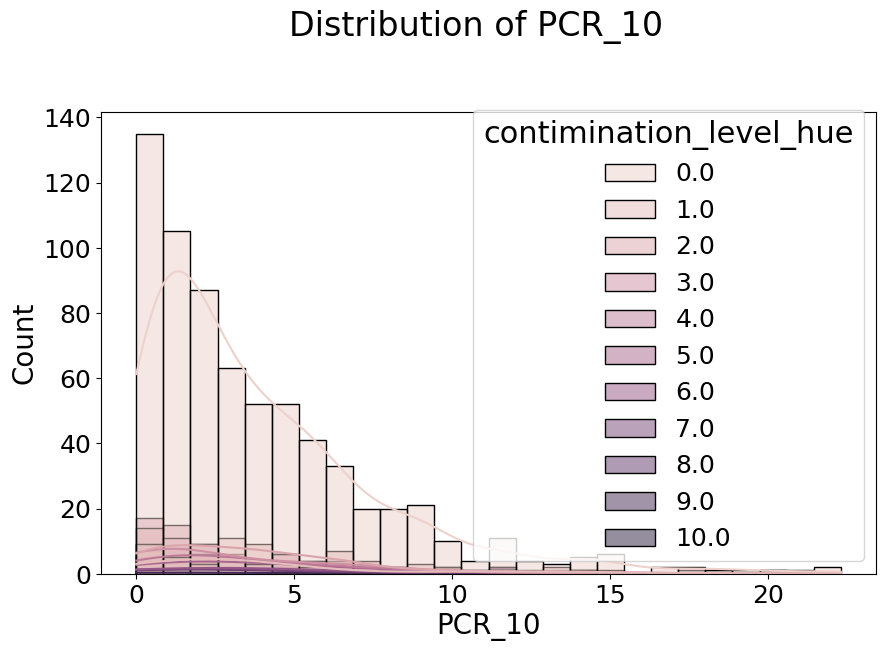

In [5]:
# plotting histograms for the features to decide on normalization
train_raw_copy = train_raw.copy()
train_raw_copy['contimination_level_hue'] = np.round(train_raw_copy['contamination_level'])
for col in [column for column in train_raw.columns if column != 'contamination_level']:
    plt.figure(figsize=(10, 6))
    g = sns.histplot(data=train_raw_copy, x=col, kde=True, hue='contimination_level_hue')
    plt.suptitle(f"Distribution of {col}", y=1.05)
    plt.show()

In [6]:
# adjusted prepare_data function for HW1

def prepare_data(training_data, new_data):
  import pandas as pd
  from sklearn.preprocessing import StandardScaler, MinMaxScaler

  new_data_copy = new_data.copy()

  #  fill the missing values
  PCR_02_median = training_data.PCR_02.median()
  new_data_copy = new_data_copy.fillna(value={"PCR_02": PCR_02_median})

  # scale features
  standard_scaler = StandardScaler()
  minmax_scaler = MinMaxScaler(feature_range=(-1,1))

  for metric in ["PCR_01", "PCR_03", "PCR_04", "PCR_06", "PCR_07", "PCR_08", "PCR_09"]:
    minmax_scaler.fit(training_data[[metric]])
    new_data_copy[metric] = minmax_scaler.transform(new_data[[metric]])

  for metric in ["PCR_02", "PCR_05", "PCR_10", "happiness_score"]:
    standard_scaler.fit(training_data[[metric]])
    new_data_copy[metric] = standard_scaler.transform(new_data_copy[[metric]])

  return new_data_copy

In [7]:
# preprocess the data, define X and y

train = prepare_data(train_raw, train_raw)
test = prepare_data(train_raw, test_raw)

X_train = train[["happiness_score", "PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05",
                      "PCR_06", "PCR_07", "PCR_08", "PCR_09", "PCR_10"]]
y_train = train[["contamination_level"]]

X_test = test[["happiness_score", "PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05",
                      "PCR_06", "PCR_07", "PCR_08", "PCR_09", "PCR_10"]]
y_test = test[["contamination_level"]]

## Section 1

In [8]:
# split into training and validation for this section only
train_sec1, validation_sec1 = train_test_split(train, test_size=0.2, random_state=103)

# define X and y
X_train_sec1 = train_sec1[["happiness_score", "PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05", "PCR_06", "PCR_07", "PCR_08", "PCR_09", "PCR_10"]]
y_train_sec1 = train_sec1["contamination_level"]

X_val_sec1 = validation_sec1[["happiness_score", "PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05", "PCR_06", "PCR_07", "PCR_08", "PCR_09", "PCR_10"]]
y_val_sec1 = validation_sec1["contamination_level"]

#### Linear Regressor Class

In [9]:
# given class

from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """
        objective = (np.dot(X, w) + b) - y
        loss = np.sum(objective ** 2) / X.shape[0]
        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """

        objective = (X.dot(w) + b) - y
        g_w = (2 * (X.T).dot(objective)) / X.shape[0]
        g_b = (2 * np.sum(objective) ) / X.shape[0]

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """
        y_pred = X.dot(self.w) + self.b
        return y_pred

#### Verify Gradients function

In [10]:
# given function

def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

#### Section 1 - Continued

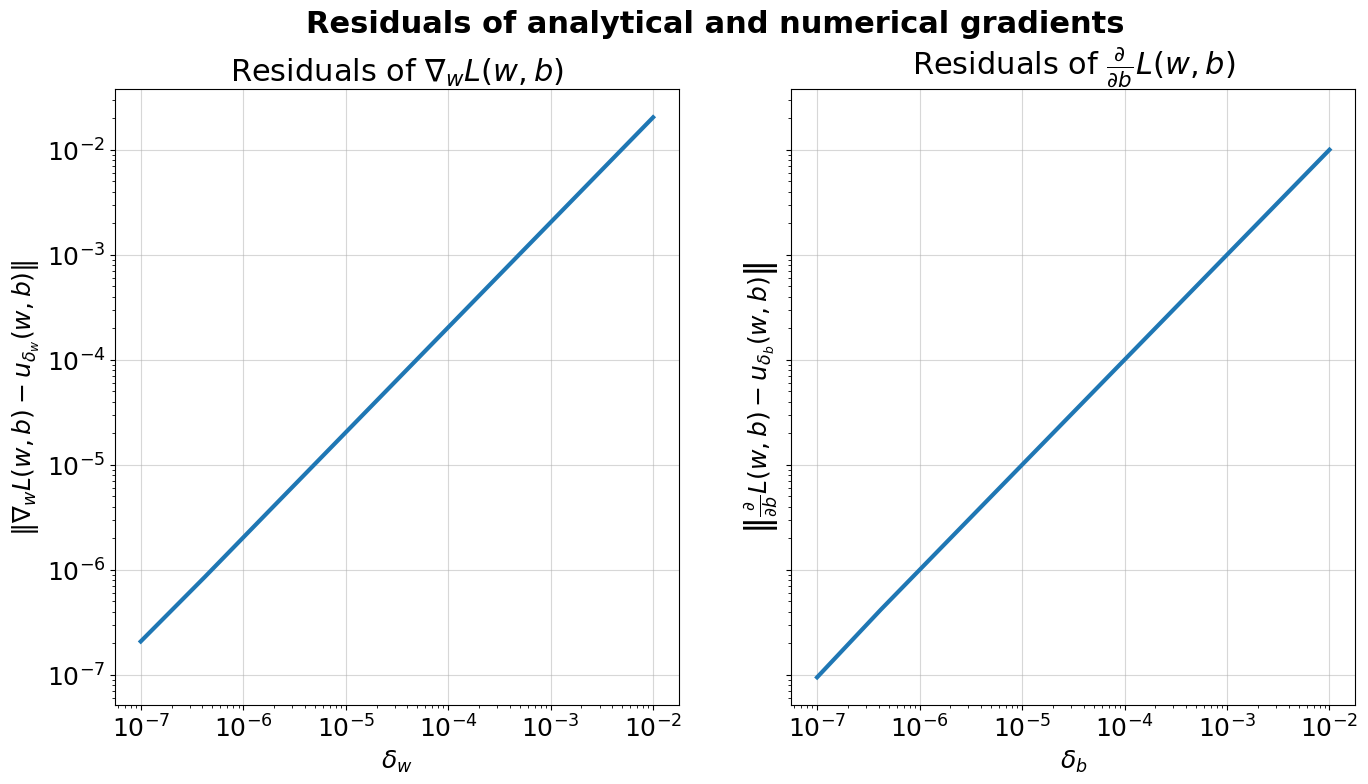

In [11]:
# run compare_gradients
compare_gradients(X_train_sec1, y_train_sec1, deltas=np.logspace(-7, -2, 9))

#### Given test-lr function

In [12]:
# given function

import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

#### Section 1 - Continued

lr size = 1e-09, Best train loss = 5.351275425807899, Best validation loss = 5.630684746558842
lr size = 1e-08, Best train loss = 5.3511423752909515, Best validation loss = 5.6305333376640805
lr size = 1e-07, Best train loss = 5.3498122530817565, Best validation loss = 5.629019682470742
lr size = 1e-06, Best train loss = 5.336549252190639, Best validation loss = 5.61392642168051
lr size = 1e-05, Best train loss = 5.207667627001212, Best validation loss = 5.4672398684289965
lr size = 0.0001, Best train loss = 4.229695034486188, Best validation loss = 4.352846258278379
lr size = 0.001, Best train loss = 2.7679027869336927, Best validation loss = 2.694264172176535
lr size = 0.01, Best train loss = 2.7329861080193623, Best validation loss = 2.681258609208978
lr size = 0.1, Best train loss = 2.7434820383096694, Best validation loss = 2.682207457936235


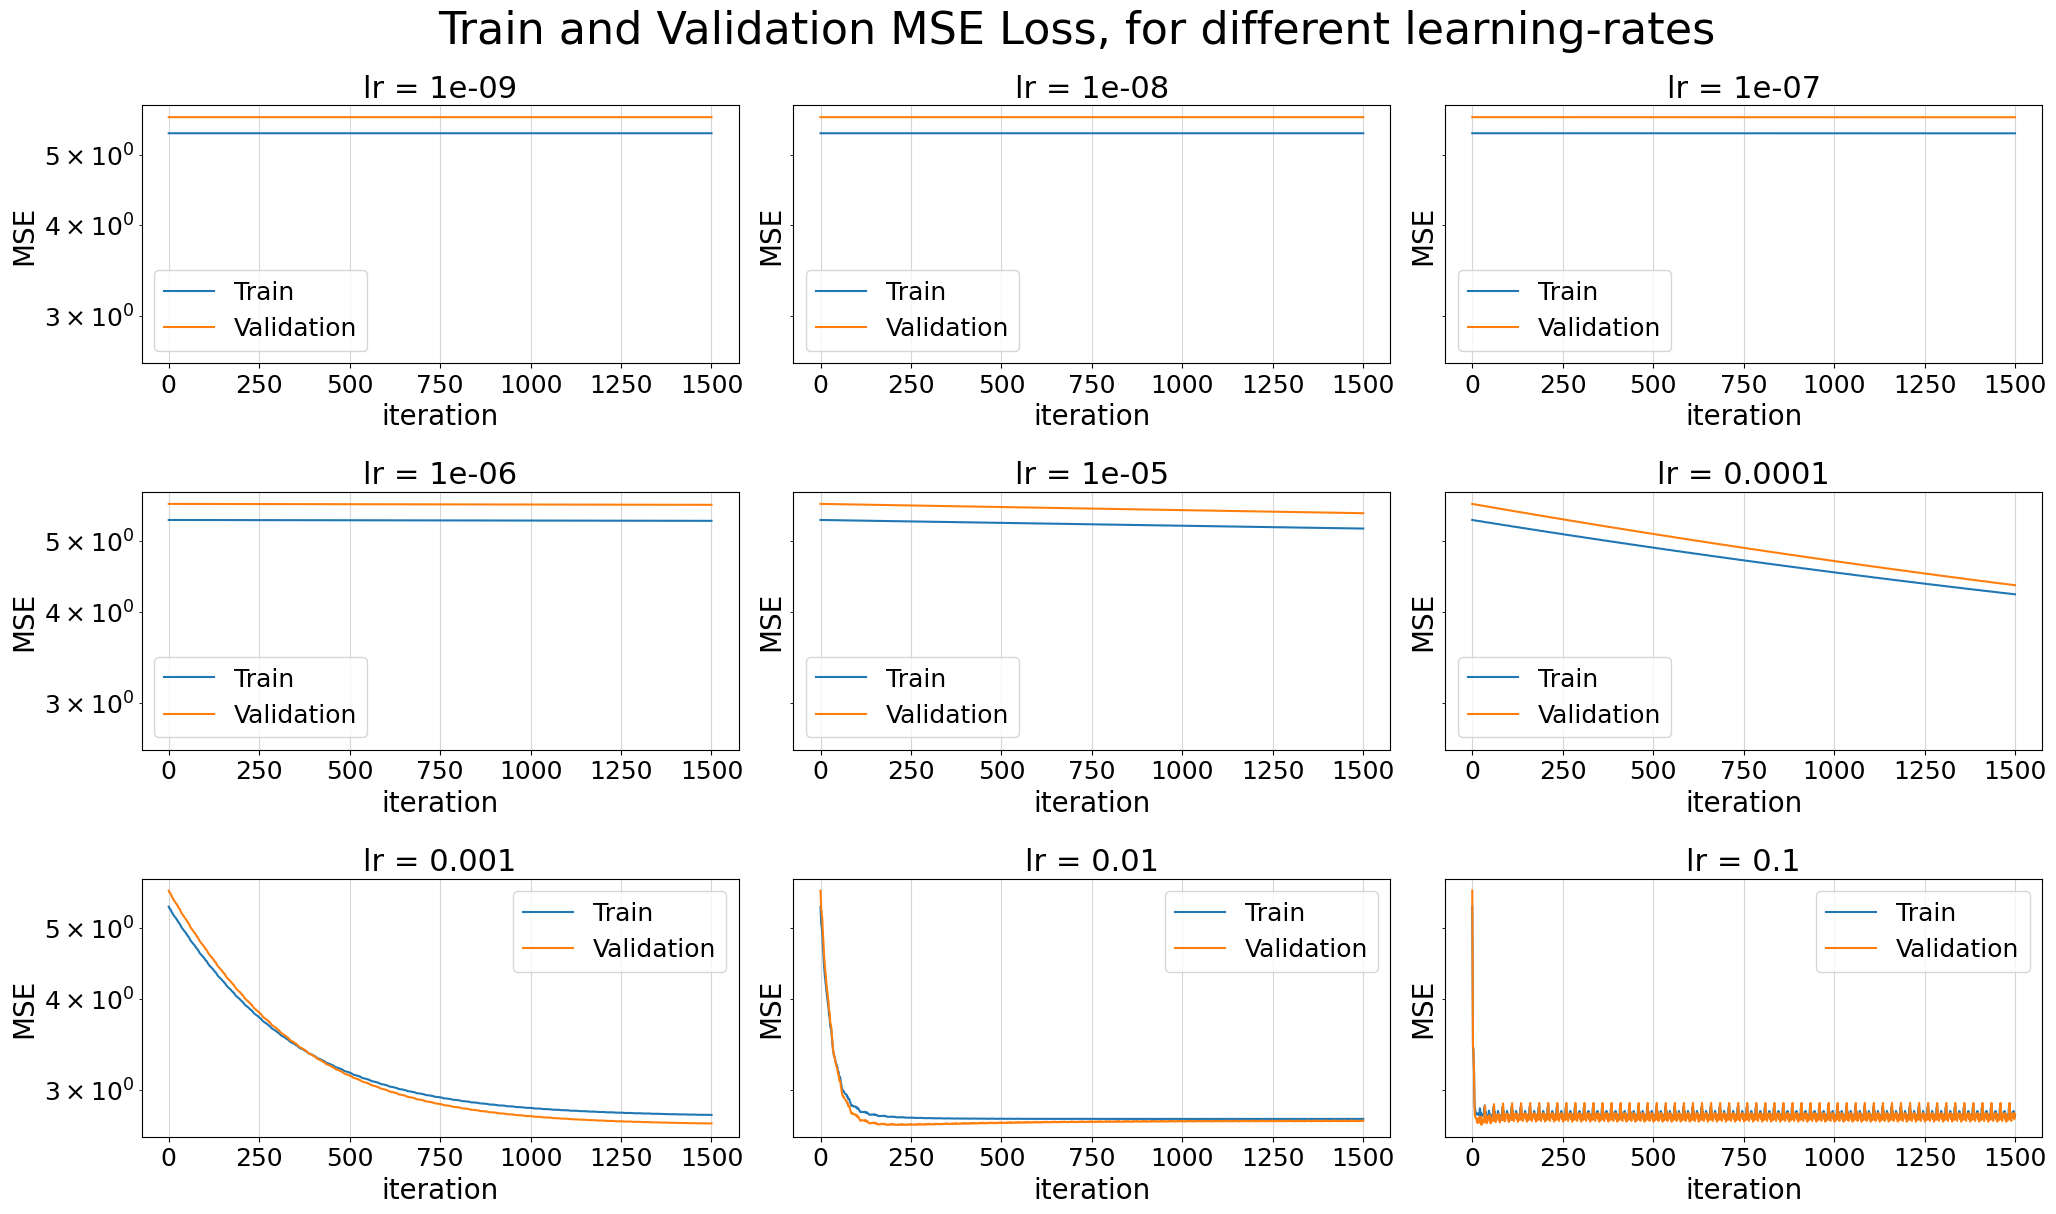

In [13]:
# run test_lr

test_lr(X_train_sec1, y_train_sec1, X_val_sec1, y_val_sec1, "Train and Validation MSE Loss, for different learning-rates")

## Section 2

#### Dummy Regressor

In [28]:
# initialize dummy regressor and cross validate
from sklearn.model_selection import cross_validate as CV
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
cv_results_dummy = CV(dummy, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
dummy_cv_mean_train_score = -cv_results_dummy['train_score'].mean()
dummy_cv_mean_test_score = -cv_results_dummy['test_score'].mean()

print(f"Dummy CV mean train score = {dummy_cv_mean_train_score:.2f}. \nDummy CV mean test score = {dummy_cv_mean_test_score:.2f}. ")

Dummy CV mean train score = 4.08. 
Dummy CV mean test score = 4.09. 


In [29]:
# fit the dummy regressor with the entire training data
dummy.fit(X_train, y_train)

DummyRegressor()

#### Linear

In [30]:
# define learning rate range, run cross validation across the range and list the mean MSEs

lr_range = np.logspace(-4, -1, 31)
mean_train_scores_sec2 = []
mean_test_scores_sec2 = []
for lr in lr_range:
    cv_results_lin = CV(LinearRegressor(lr), np.array(X_train), np.array(y_train).flatten(), cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    mean_train_scores_sec2.append(-cv_results_lin['train_score'].mean())
    mean_test_scores_sec2.append(-cv_results_lin['test_score'].mean())

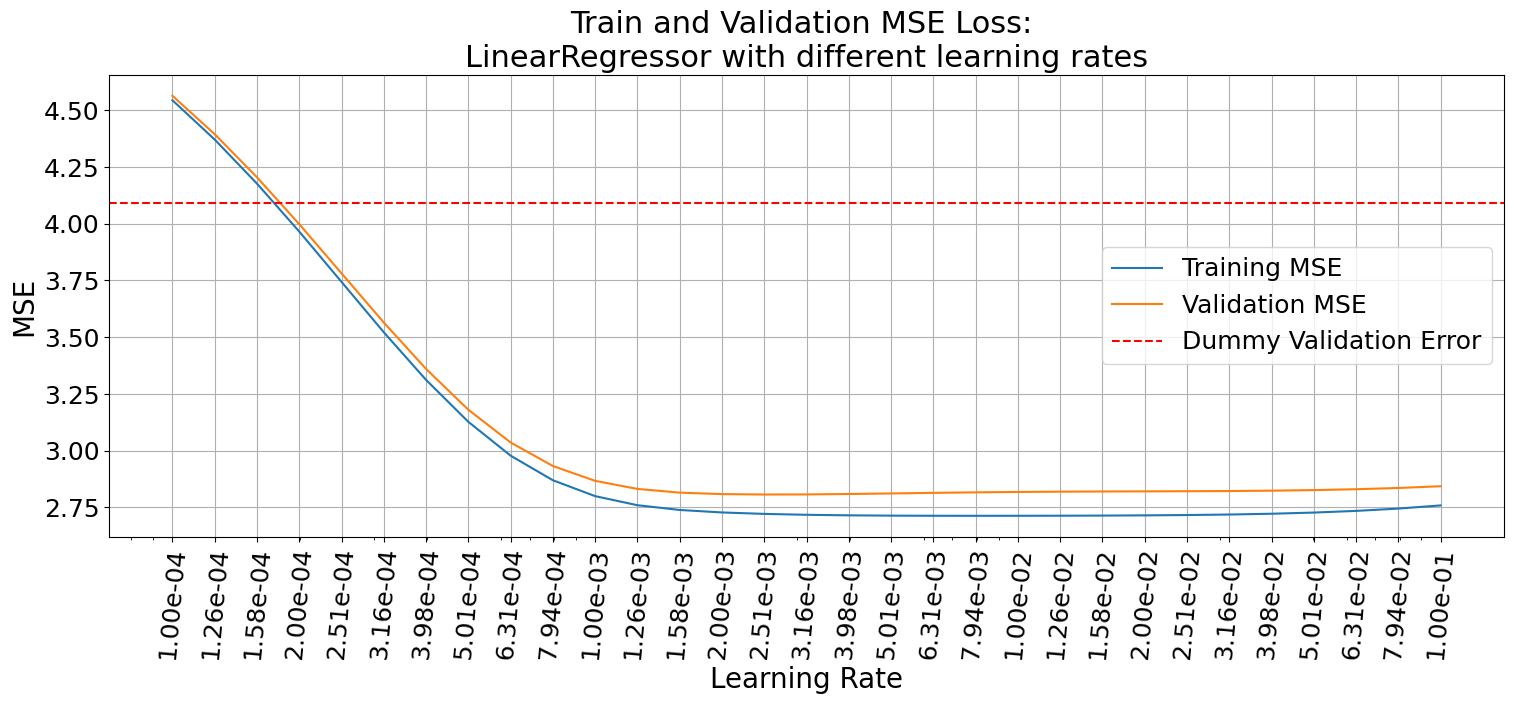

In [31]:
# plot cross validation scores

plt.figure(figsize=(18, 6))
plt.semilogx(lr_range, mean_train_scores_sec2, label='Training MSE')
plt.semilogx(lr_range, mean_test_scores_sec2, label='Validation MSE')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.title('Train and Validation MSE Loss: \nLinearRegressor with different learning rates')
plt.axhline(y=dummy_cv_mean_test_score, color='r', linestyle='--', label='Dummy Validation Error')
plt.xticks(lr_range, [f'{value:.2e}' for value in lr_range], rotation=85)
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# train linear regressor with the optimal lr, get cross validated scores
optimal_lr = 2e-3
optimal_linear_regressor = LinearRegressor(optimal_lr)
cv_results_lin_opt = CV(optimal_linear_regressor, np.array(X_train), np.array(y_train).flatten(), cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print(f"{-cv_results_lin_opt['train_score'].mean():.2f}", f"{-cv_results_lin_opt['test_score'].mean():.2f}")

2.73 2.81


In [39]:
# fit the linear regressor on the entire training set
optimal_linear_regressor.fit(np.array(X_train), np.array(y_train).flatten())

LinearRegressor(lr=0.002)

## Section 3

In [40]:
# set range for alpha and cross validate across the different alphas, list the scores

from sklearn.linear_model import Lasso

a_range = np.logspace(-4, 2, 41)
mean_train_scores_sec3 = []
mean_test_scores_sec3 = []

for a in a_range:
    cv_results_lasso = CV(Lasso(alpha=a, fit_intercept=True), X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    mean_train_scores_sec3.append(-cv_results_lasso['train_score'].mean())
    mean_test_scores_sec3.append(-cv_results_lasso['test_score'].mean())

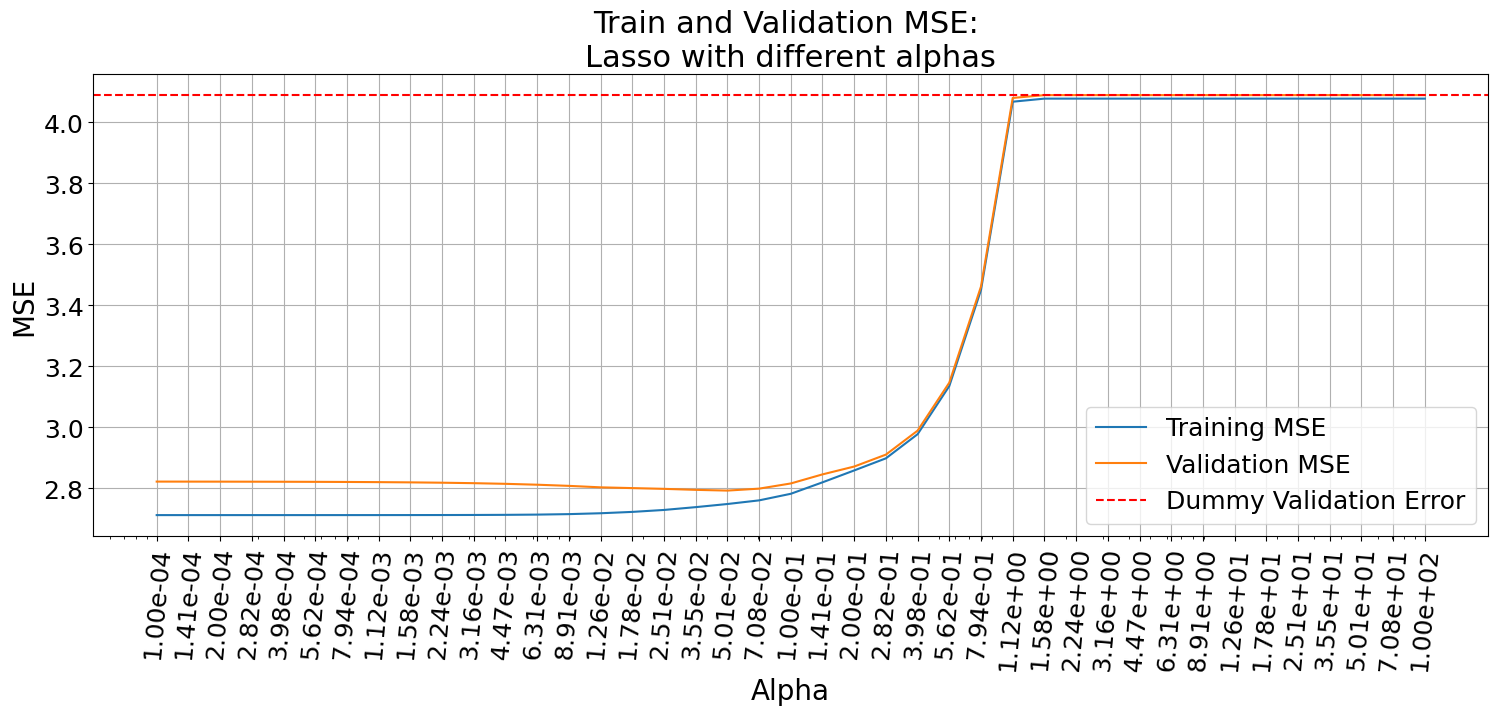

In [41]:
# plot cross validation scores
plt.figure(figsize=(18, 6))
plt.semilogx(a_range, mean_train_scores_sec3, label='Training MSE')
plt.semilogx(a_range, mean_test_scores_sec3, label='Validation MSE')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Train and Validation MSE: \nLasso with different alphas')
plt.axhline(y=dummy_cv_mean_test_score, color='r', linestyle='--', label='Dummy Validation Error')
plt.xticks(a_range, [f'{value:.2e}' for value in a_range], rotation=85)
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# train lasso regressor with the optimal alpha, get cross validation scores
optimal_alpha = 5e-2
optimal_lasso_regressor = Lasso(alpha=optimal_alpha, fit_intercept=True)
cv_results = CV(optimal_lasso_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print(f"{-cv_results['train_score'].mean():.2f}", f"{-cv_results['test_score'].mean():.2f}")

2.75 2.79


In [43]:
# fit the lasso regressor with the entire training set
optimal_lasso_regressor.fit(X_train, y_train)

Lasso(alpha=0.05)

In [44]:
# view the coefficients of the optimal lasso regressor
optimal_lasso_regressor.coef_

array([ 1.07670152,  0.        , -0.        ,  0.32620593, -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ])

Text(0.5, 1.0, 'Feature Absolute Values')

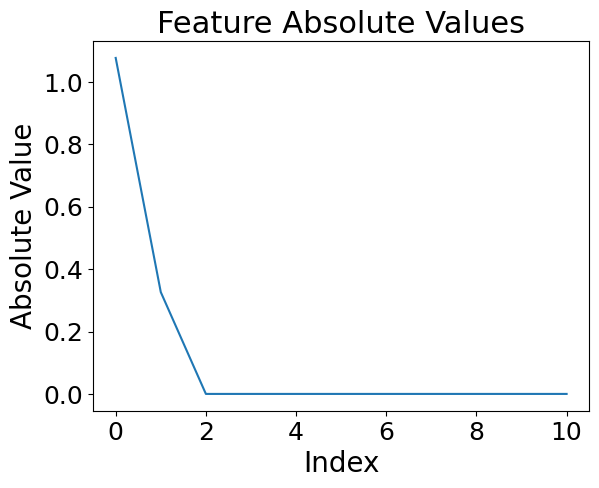

In [45]:
# plot coefficients values
sorted_coefficients = sorted(optimal_lasso_regressor.coef_, key=abs, reverse=True)
plt.plot(list(range(len(sorted_coefficients))), [abs(value) for value in sorted_coefficients])
plt.xlabel("Index")
plt.ylabel("Absolute Value")
plt.title("Feature Absolute Values")

## Section 4

In [46]:
#create subset for this section

train_sec4 = train[['PCR_03', 'PCR_07', 'contamination_level']]

X_train_sec4 = train_sec4[['PCR_03', 'PCR_07']]
y_train_sec4 = train_sec4[['contamination_level']]

### plot3d function

In [47]:
# given function

def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

### Section 4 - cont.

<ipython-input-47-fe7698011ed8>:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


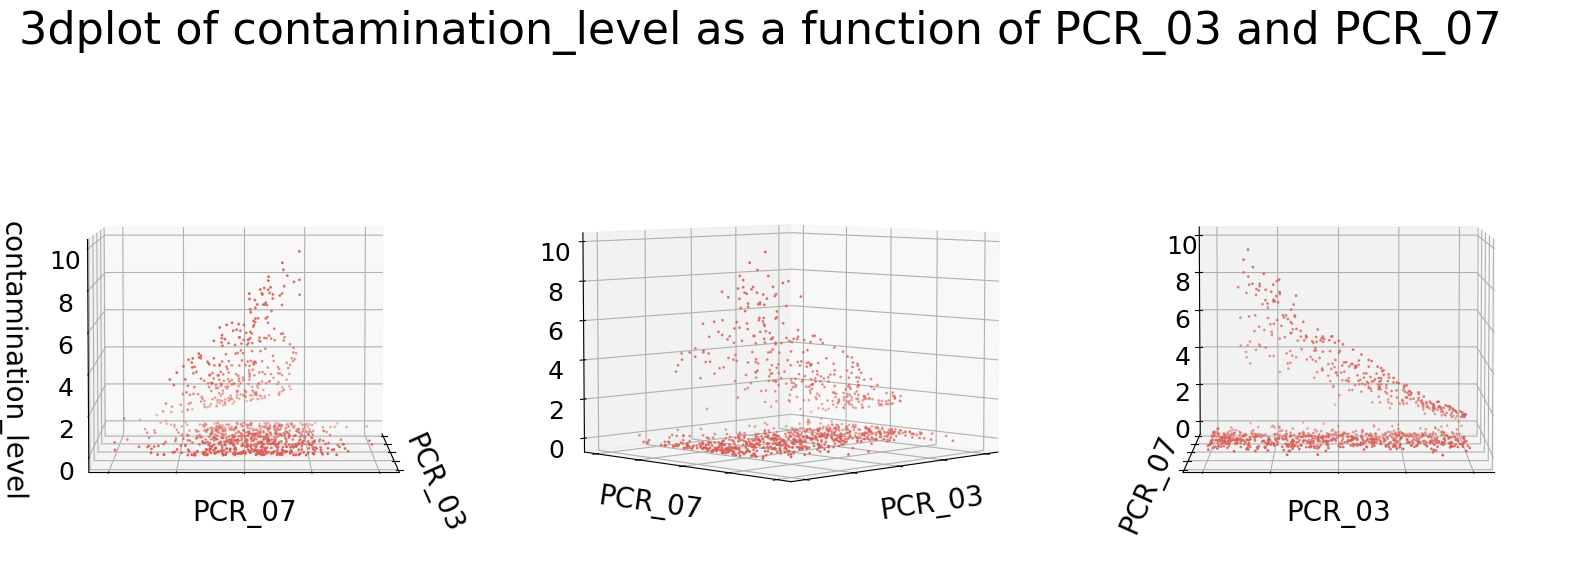

In [48]:
# make 3d plot of the training subset

plot3d(train_sec4, 'PCR_03', 'PCR_07', 'contamination_level', '3dplot of contamination_level as a function of PCR_03 and PCR_07')

In [52]:
# make a pipline and cross validate across different lambdas (alphas), list cv scores

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

Lambda_range = np.logspace(-4, -1, 11)
mean_train_scores_sec4 = []
mean_test_scores_sec4 = []

for Lambda in Lambda_range:
    poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),  ('normalization', MinMaxScaler()),  ('Lasso', Lasso(alpha=Lambda, fit_intercept=True))])
    cv_results_poly_lasso = CV(poly_reg, X_train_sec4, y_train_sec4, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    mean_train_scores_sec4.append(-cv_results_poly_lasso['train_score'].mean())
    mean_test_scores_sec4.append(-cv_results_poly_lasso['test_score'].mean())

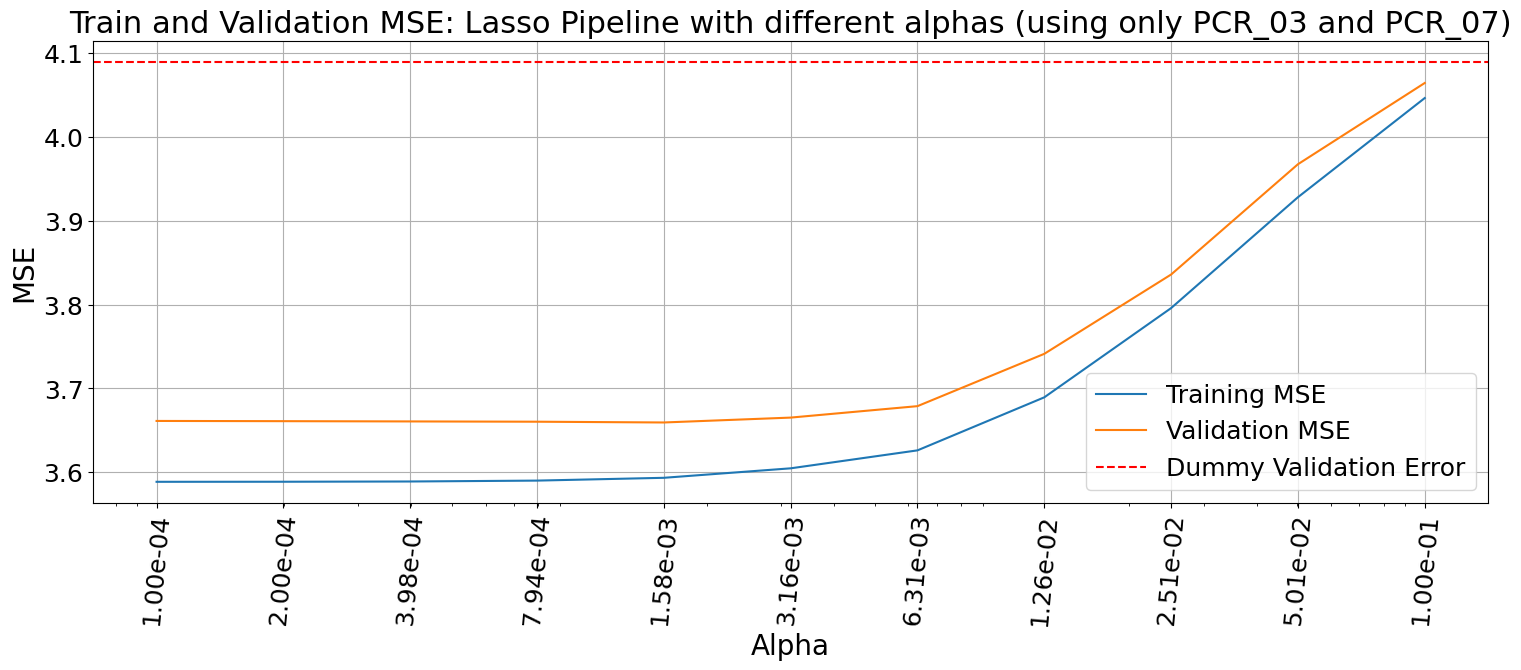

In [53]:
# plot scores
plt.figure(figsize=(18, 6))
plt.semilogx(Lambda_range, mean_train_scores_sec4, label='Training MSE')
plt.semilogx(Lambda_range, mean_test_scores_sec4, label='Validation MSE')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Train and Validation MSE: Lasso Pipeline with different alphas (using only PCR_03 and PCR_07)')
plt.axhline(y=dummy_cv_mean_test_score, color='r', linestyle='--', label='Dummy Validation Error')
plt.xticks(Lambda_range, [f'{value:.2e}' for value in Lambda_range], rotation=85)
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# train using optimal lambda and get cross validation results

optimal_Lambda = 1e-4
optimal_poly_lasso_regressor = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),  ('normalization', MinMaxScaler()),  ('Lasso', Lasso(alpha=optimal_Lambda, fit_intercept=True))])
cv_results = CV(optimal_poly_lasso_regressor, X_train_sec4, y_train_sec4, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print(f"{-cv_results['train_score'].mean():.2f}", f"{-cv_results['test_score'].mean():.2f}")

3.59 3.66


In [55]:
# fit with the entire trainig data (ONLY PCR_03 and PCR_07)
optimal_poly_lasso_regressor.fit(X_train_sec4, y_train_sec4)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=3)),
                ('normalization', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.0001))])

<ipython-input-47-fe7698011ed8>:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


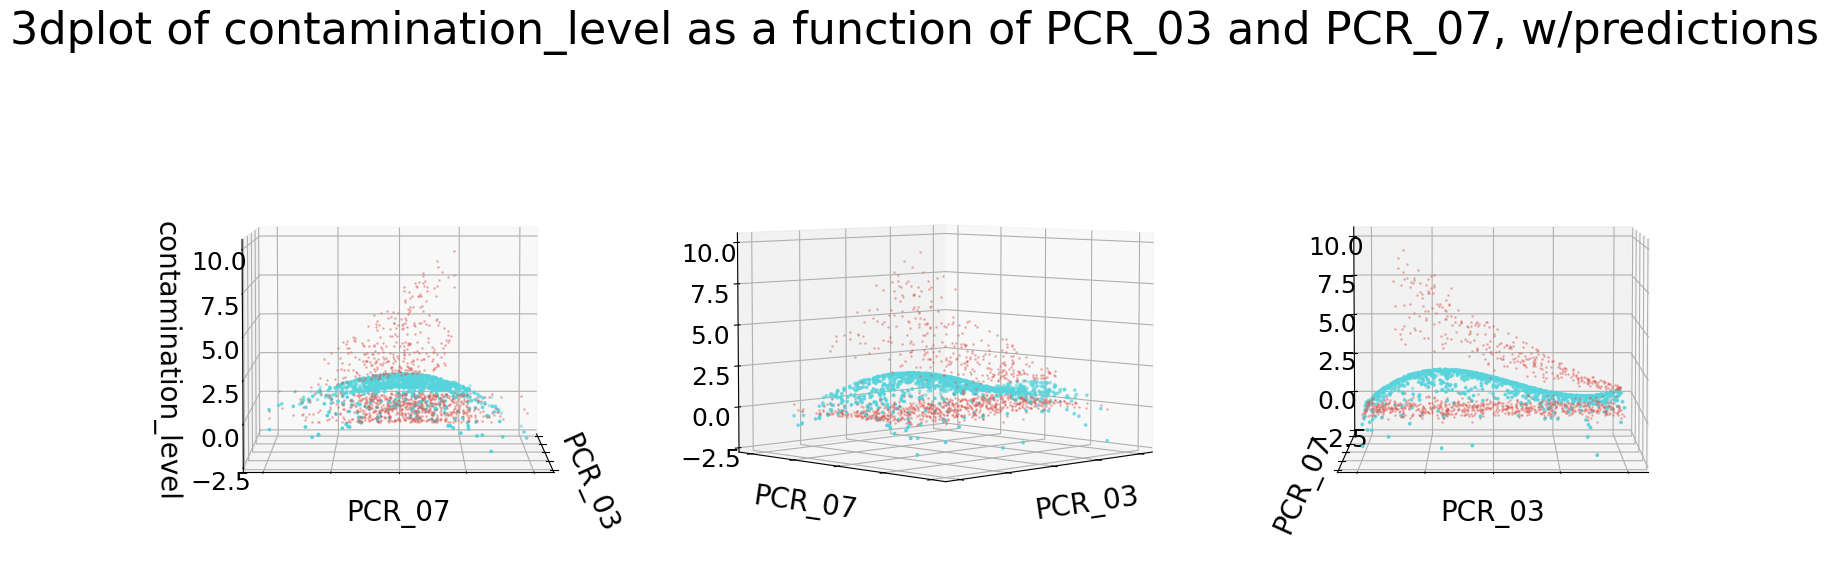

In [56]:
# make a 3d plot of the samples and predictions
plot3d(train_sec4, 'PCR_03', 'PCR_07', 'contamination_level', '3dplot of contamination_level as a function of PCR_03 and PCR_07, w/predictions', predictions=optimal_poly_lasso_regressor.predict(X_train_sec4))

## Section 5

### finding most relevant features for this section

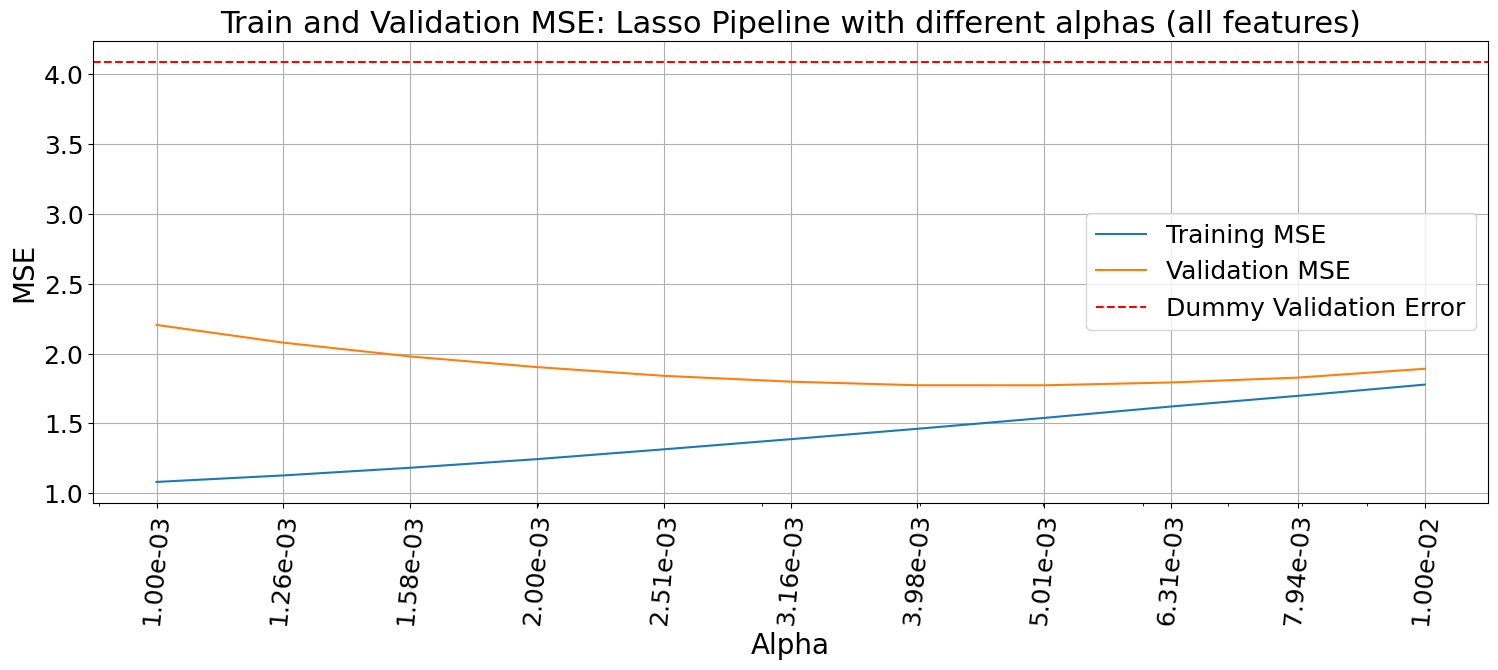

In [60]:
# finding most relevant features based on the coefficients of a polynomial Lasso regressor trained on the entire training set, plot the scores

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

alpha_range_sec5 = np.logspace(-3,-2,11)
mean_train_scores_sec5 = []
mean_test_scores_sec5 = []

for alpha in alpha_range_sec5:
    poly_reg_sec5 = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),  ('normalization', MinMaxScaler()),  ('Lasso', Lasso(alpha=alpha, fit_intercept=True))])
    cv_results_poly_sec5 = CV(poly_reg_sec5, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    mean_train_scores_sec5.append(-cv_results_poly_sec5['train_score'].mean())
    mean_test_scores_sec5.append(-cv_results_poly_sec5['test_score'].mean())

plt.figure(figsize=(18, 6))
plt.semilogx(alpha_range_sec5, mean_train_scores_sec5, label='Training MSE')
plt.semilogx(alpha_range_sec5, mean_test_scores_sec5, label='Validation MSE')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Train and Validation MSE: Lasso Pipeline with different alphas (all features)')
plt.axhline(y=dummy_cv_mean_test_score, color='r', linestyle='--', label='Dummy Validation Error')
plt.xticks(alpha_range_sec5, [f'{value:.2e}' for value in alpha_range_sec5], rotation=85)
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# train model with optimal alpha, find largest coefficients in absolute value.
opt_poly_lasso_sec5 = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),  ('normalization', MinMaxScaler()),  ('Lasso', Lasso(alpha=5e-3, fit_intercept=True))])
opt_poly_lasso_sec5.fit(X_train, y_train)
coefficient_list = opt_poly_lasso_sec5.named_steps['Lasso'].coef_
feature_name_list = opt_poly_lasso_sec5.named_steps['feature_mapping'].get_feature_names_out()
coefficients_with_names_dict = dict(zip(feature_name_list, coefficient_list))
for feature_name, coefficient in (sorted(coefficients_with_names_dict.items(), key=lambda item: abs(item[1]), reverse=True)):
    if abs(coefficient) > 0.1:
        print(f"{feature_name}: {coefficient}")

happiness_score: 10.22712854757842
happiness_score^2: 7.303516181121201
happiness_score PCR_07^2: -4.492739218061516
PCR_03^3: -3.6678208339245137
happiness_score PCR_03^2: -3.578163176236221
PCR_03: 3.082851913305021
happiness_score PCR_03: 2.7642394632928693
PCR_07^2: -2.246216536096901
happiness_score^2 PCR_03: 1.1799613715467356
PCR_03^2: -1.0901483619858252
PCR_03 PCR_05 PCR_07: 0.6143627351651775
PCR_05 PCR_07 PCR_10: -0.6009581752647689
PCR_01 PCR_03: 0.46562738868718023
PCR_06 PCR_09: -0.4225956879538012
PCR_09^2: 0.42091834881213414
happiness_score PCR_06 PCR_08: 0.25486504472884847
PCR_01 PCR_03 PCR_06: -0.23726711658145289
PCR_04 PCR_06: 0.15924559010160816


### section 5 - continued

In [63]:
# make a copy of the dataset for this section, using only relevant features

from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import GridSearchCV

train_sec5 = train.copy()
test_sec5 = test.copy()

X_train_sec5 = train_sec5[['happiness_score', 'PCR_03', 'PCR_07']]
y_train_sec5 = train_sec5[['contamination_level']]

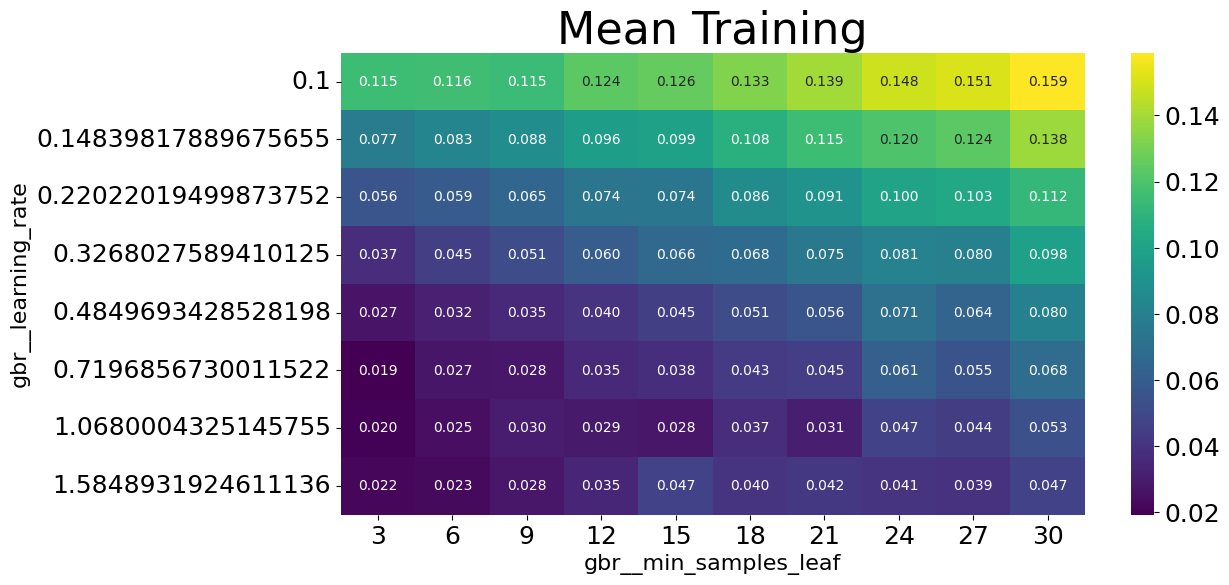

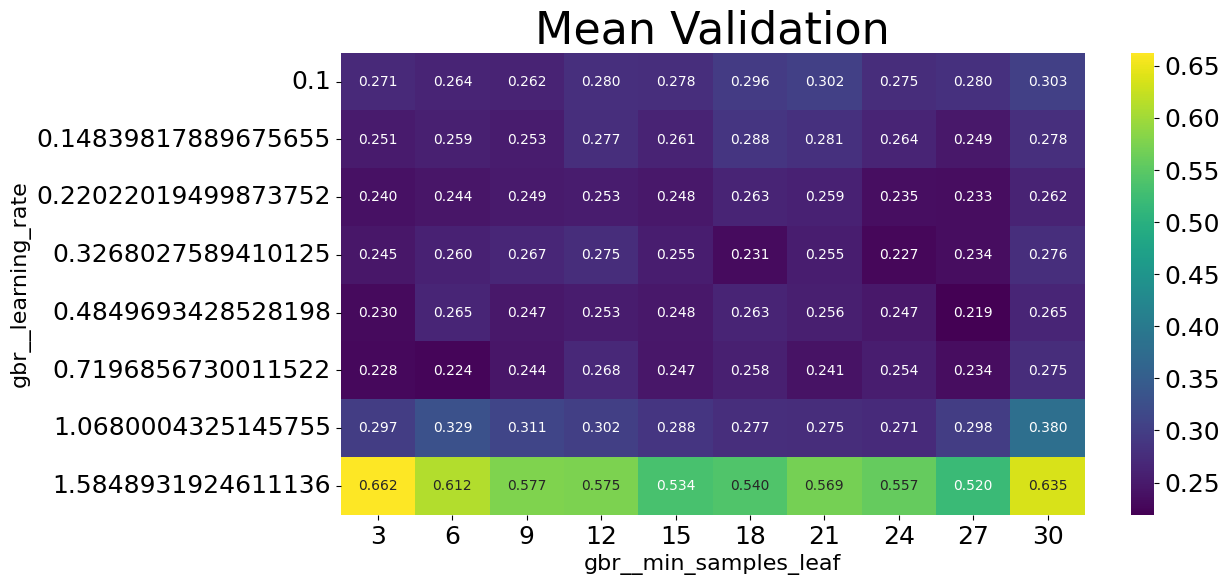

In [65]:
# grid search CV for different learning rates and min_sample_leaf for the polynomial gbr
poly_gbr = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),  ('normalization', MinMaxScaler()),
 ('gbr', (GBR(loss='huber')))])

param_grid = {
       'gbr__learning_rate':  np.logspace(-1, 0.2, 8),
       'gbr__min_samples_leaf': list(range(3, 31, 3))
   }

GSCV = GridSearchCV(poly_gbr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
GSCV.fit(X_train_sec5, np.array(y_train_sec5).flatten())

# get the grid search cross validation results

cv_results_poly_gbr = GSCV.cv_results_

train_scores = -cv_results_poly_gbr['mean_train_score'].reshape(len(param_grid['gbr__learning_rate']), len(param_grid['gbr__min_samples_leaf']))
validation_scores = -cv_results_poly_gbr['mean_test_score'].reshape(len(param_grid['gbr__learning_rate']), len(param_grid['gbr__min_samples_leaf']))

# plot heatmap of train scores

plt.figure(figsize=(12,6))
training_heatmap = sns.heatmap(train_scores, annot=True, fmt=".3f", cmap="viridis", xticklabels=param_grid['gbr__min_samples_leaf'], yticklabels=param_grid['gbr__learning_rate'])
plt.title("Mean Training", fontsize=32)
plt.xlabel("gbr__min_samples_leaf", fontsize=16)
plt.ylabel("gbr__learning_rate", fontsize=16)
plt.show()

# plot heatmap of validation scores

plt.figure(figsize=(12,6))
validation_heatmap = sns.heatmap(validation_scores, annot=True, fmt=".3f", cmap="viridis", xticklabels=param_grid['gbr__min_samples_leaf'], yticklabels=param_grid['gbr__learning_rate'])
plt.title("Mean Validation", fontsize=32)
plt.xlabel("gbr__min_samples_leaf", fontsize=16)
plt.ylabel("gbr__learning_rate", fontsize=16)
plt.show()

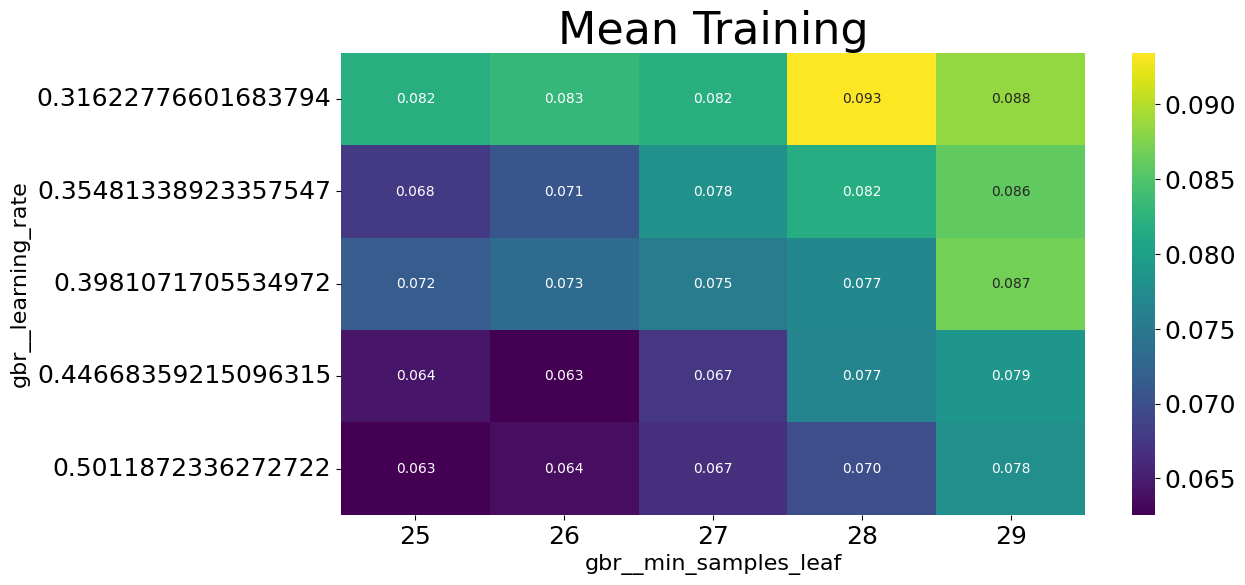

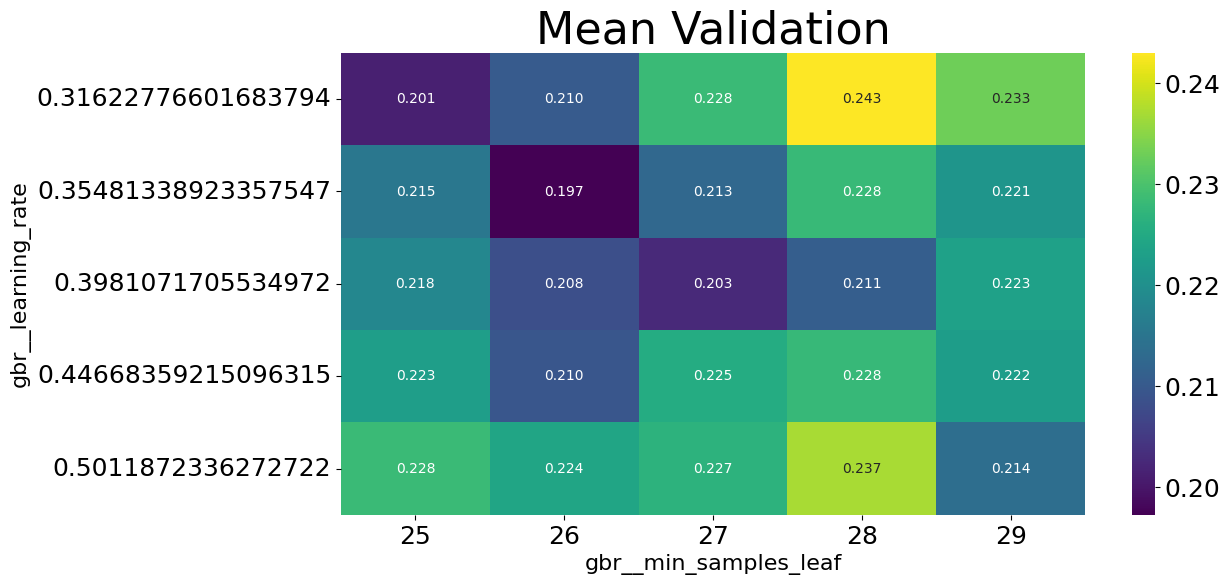

In [66]:
# run grid search CV again with narrower parameter ranges

poly_gbr = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),  ('normalization', MinMaxScaler()),
 ('gbr', (GBR(loss='huber')))])

param_grid = {
       'gbr__learning_rate':  np.logspace(-0.5, -0.3, 5),
       'gbr__min_samples_leaf': list(range(25, 30, 1))
   }

GSCV = GridSearchCV(poly_gbr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
GSCV.fit(X_train_sec5, np.array(y_train_sec5).flatten())

# get the cross validation results

cv_results = GSCV.cv_results_

train_scores = -cv_results['mean_train_score'].reshape(len(param_grid['gbr__learning_rate']), len(param_grid['gbr__min_samples_leaf']))
validation_scores = -cv_results['mean_test_score'].reshape(len(param_grid['gbr__learning_rate']), len(param_grid['gbr__min_samples_leaf']))

# plot heatmap of train scores

plt.figure(figsize=(12,6))
training_heatmap = sns.heatmap(train_scores, annot=True, fmt=".3f", cmap="viridis", xticklabels=param_grid['gbr__min_samples_leaf'], yticklabels=param_grid['gbr__learning_rate'])
plt.title("Mean Training", fontsize=32)
plt.xlabel("gbr__min_samples_leaf", fontsize=16)
plt.ylabel("gbr__learning_rate", fontsize=16)
plt.show()

# plot heatmap of validation scores

plt.figure(figsize=(12,6))
validation_heatmap = sns.heatmap(validation_scores, annot=True, fmt=".3f", cmap="viridis", xticklabels=param_grid['gbr__min_samples_leaf'], yticklabels=param_grid['gbr__learning_rate'])
plt.title("Mean Validation", fontsize=32)
plt.xlabel("gbr__min_samples_leaf", fontsize=16)
plt.ylabel("gbr__learning_rate", fontsize=16)
plt.show()

In [67]:
# train model with the optimal parameters, get cross validation scores

optimal_gbr_learning_rate = 0.35
optimal_gbr_min_samples_leaf = 26
optimal_poly_gbr = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),  ('normalization', MinMaxScaler()),
 ('gbr', (GBR(loss='huber', learning_rate=optimal_gbr_learning_rate, min_samples_leaf=optimal_gbr_min_samples_leaf)))])
cv_results_poly_gbr_opt = CV(optimal_poly_gbr, X_train_sec5, np.array(y_train_sec5).flatten(), cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print(f"{-cv_results_poly_gbr_opt['train_score'].mean():.2f}", f"{-cv_results_poly_gbr_opt['test_score'].mean():.2f}")

0.08 0.20


In [68]:
# fit the model with the entire training set

optimal_poly_gbr.fit(X_train_sec5,  np.array(y_train_sec5).flatten())

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=3)),
                ('normalization', MinMaxScaler()),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.35, loss='huber',
                                           min_samples_leaf=26))])

## Section 6

In [74]:
from sklearn.metrics import mean_squared_error

# define the test set for each model
X_test = test[["happiness_score", "PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05",
                      "PCR_06", "PCR_07", "PCR_08", "PCR_09", "PCR_10"]]
y_test = test[["contamination_level"]]

X_test_2_features = test[["PCR_03", "PCR_07"]]
X_test_3_features = test[["happiness_score", "PCR_03", "PCR_07"]]

# get predictions for each model
pred_dummy = dummy.predict(X_test)
pred_linear = optimal_linear_regressor.predict(X_test)
pred_lasso = optimal_lasso_regressor.predict(X_test)
pred_poly_lasso = optimal_poly_lasso_regressor.predict(X_test_2_features)
pred_poly_gbr = optimal_poly_gbr.predict(X_test_3_features)

# calculate MSE for each model
mse_dummy = mean_squared_error(y_test, pred_dummy)
mse_linear = mean_squared_error(y_test, pred_linear)
mse_lasso = mean_squared_error(y_test, pred_lasso)
mse_poly_lasso = mean_squared_error(y_test, pred_poly_lasso)
mse_poly_gbr = mean_squared_error(y_test, pred_poly_gbr)

# print MSE values
print(f"Dummy Regressor MSE: {mse_dummy:.2f}")
print(f"Linear Regressor MSE: {mse_linear:.2f}")
print(f"Lasso Regressor MSE: {mse_lasso:.2f}")
print(f"Polynomial Lasso Regressor MSE: {mse_poly_lasso:.2f}")
print(f"Polynomial Gradient Boosting Regressor MSE: {mse_poly_gbr:.2f}")

Dummy Regressor MSE: 3.78
Linear Regressor MSE: 2.73
Lasso Regressor MSE: 2.73
Polynomial Lasso Regressor MSE: 3.52
Polynomial Gradient Boosting Regressor MSE: 0.24
